# Обучение генеральных моделей
---

## Загрузка и сборка данных

Подгрузим модули и библиотеки.

In [1]:
# Для работы с числами и таблицами
import numpy as np
import pandas as pd
# Для работы с файлами директории
import os
# Для подгрузки ранее сохраненных в файл данных
import joblib
# Обработка предупреждений
import warnings

# Для составления комбинаций
from itertools import combinations

# Модули sklearn для работы с данными
from sklearn import preprocessing
from sklearn import decomposition
from sklearn import model_selection
from sklearn import metrics
from sklearn import linear_model
from sklearn import svm
from sklearn import kernel_approximation

# Оконная функция для обработки данных
from scipy import signal

# Инструменты визуализации
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

# Progress bar
from tqdm import tqdm
# Для таймеров
import time

### Утилиты ввода-вывода

Следующая функция была предоставлена Моторикой в бейзлайне решения. Она нужна для распаковки palm-файлов, в которых и находятся данные ОМГ-датчиков.

In [2]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

### Сокращения
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC — encoders (fingers of prosthesis or gloves)  
model — model of data  

### Данные

In [3]:
# Подгрузка метаданных
df_meta = pd.read_csv('./data/data_from_4_pilots/meta_information.csv', index_col=0)
# Сохраним вектор наименований файлов
fils = df_meta['montage'].apply(lambda x: x.split('.')[0]).values
# Сохраним вектор лейблов id пилотов
pilotes = df_meta['pilote_id'].values

# Подгрузка массива отчетов
runs_reports = np.load('derivatives/reports.npy')

# Загружаем список моделей 
loaded_list_of_models = joblib.load('derivatives/models_list.pkl')

И выведем отчет по прогонам данных через алгоритм МО, как мы это делали в тетрадке `runs_report`.

In [4]:
# Выбор номера модели в списке: от 1 до 20
i=20
print('Отчет по алгоритму:')
# print(models[i])
print(loaded_list_of_models[i-1])

# Соберем таблицу отчета
report = pd.DataFrame(
    data=np.hstack(
        (fils.reshape(-1, 1),
         pilotes.reshape(-1, 1),
         np.round(runs_reports[i-1], 6))),
    columns=[
        'file', 'pilote_id', 'Corr', 'corr_a', 'corr_b', 'f1_test',
        'Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
)

# Разукрасим таблицуу для облегчения восприятия
report.style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(report.columns)[2:]
)

Отчет по алгоритму:


,file,pilote_id,Corr,corr_a,corr_b,f1_test,Neutral,Open,Pistol,Thumb,OK,Grab
0,2023-05-15_16-16-08,1,0.274356,0.412871,0.256877,0.833128,0.902053,0.919192,0.641727,0.307978,0.779570,0.897368
1,2023-05-15_17-12-24,1,0.020546,0.191707,0.023858,0.636806,0.766574,0.801498,0.212488,0.068650,0.363144,0.572864
2,2023-06-05_16-12-38,1,0.341675,0.448190,0.339225,0.660268,0.818091,0.776025,0.271523,0.000000,0.560907,0.596623
3,2023-06-05_17-53-01,1,0.353172,0.264307,0.413203,0.746547,0.834416,0.785276,0.680973,0.373757,0.643200,0.644118
4,2023-06-20_14-43-11,1,0.083280,0.179436,0.182742,0.703648,0.811977,0.809892,0.452763,0.321569,0.633562,0.545151
5,2023-06-20_13-30-15,1,0.274443,0.235754,0.382149,0.753380,0.823946,0.830688,0.416510,0.519573,0.748538,0.776642
6,2023-06-20_12-34-17,1,0.361622,0.414341,0.356253,0.753033,0.846345,0.846154,0.692982,0.067183,0.714514,0.788945
7,2023-09-30_08-06-44,2,0.400822,0.443222,0.358299,0.907203,0.931129,0.882283,0.845927,0.946067,0.782946,0.913140
8,2023-09-29_11-03-50,2,0.346494,0.384182,0.456843,0.920865,0.936647,0.901176,0.922910,0.941950,0.840376,0.886878
9,2023-09-29_09-20-47,2,0.271879,0.363008,0.308670,0.924883,0.940181,0.897527,0.924319,0.915292,0.902386,0.877990


Здесь мы также определим псевдонимы сборок признаков и список наименований классов жестов.

In [5]:
OMG_CH = [str(i) for i in range(50)]
ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

### Функция смещения таргета

Далее при подгрузке и конкатенации данных нам понадобится в конвейерном режиме смещать таргет.

In [6]:
def get_naive_centering(X_arr, y_arr, gap=500, inter=1000, window=20, use_m=True, model=svm.SVC()):
    """Функция для устранения глобального лага между сигналами датчиков и таргетом.

    Args:
        X_arr (ndarray): Массив данных.
        y_arr (ndarray): Вектор целевого признака.
        gap (int, optional): Размеры концевых отступов. Defaults to 500.
        inter (int, optional): Величина концевых выборок. Defaults to 1000.
        window (int, optional): Величина окна поиска оптимального сдвига. Defaults to 20.
        use_m (bool, optional): Использование модели для поиска оптимального сдвига.
            Defaults to True. False: поиск сдвига по корреляции таргета с вектором
            суммы модулей дифференциалов векторов признаков массива данных.
        model (_type_, optional): Алгоритм scikit-learn. Defaults to svm.SVC().

    Returns:
        tuple():
            ndarray: Вектор сдвинутого таргета.
            list: Строки отчета по проделанным операциям.
    """
    # part of the data from the beginning
    X_part1 = X_arr[gap:gap+inter]
    y_part1 = y_arr[gap:gap+inter]
    # part of the data from the end
    X_part2 = X_arr[-gap-inter:-gap]
    y_part2 = y_arr[-gap-inter:-gap]
    
    # Функция для сдвига таргета
    def shifter(y_arr, shift=1):
        first_element = y_arr[0]
        prefix = np.full(shift, first_element)
        y_arr_shifted = np.concatenate((prefix, y_arr))[:-shift]
    
        return y_arr_shifted
    
    # Функция для расчета точности модели
    def get_score(X, y, model=model):
        model = model
        model.fit(X, y)
        preds = model.predict(X)
        
        return metrics.accuracy_score(y, preds)
    
    # Функция для расчета корреляции
    def get_corr(X, y):
        x_diff = pd.DataFrame(X).diff().abs().sum(axis=1)
        correlation = np.corrcoef(x_diff, y)[0, 1]
        
        return abs(correlation)
    
    
    max_score1, current_score1 = 0, 0
    max_score2, current_score2 = 0, 0
    s1, s2 = 1, 1
    
    for i in range(1, window+1):
        y_a = shifter(y_part1, shift=i)
        y_b = shifter(y_part2, shift=i)
        
        if use_m:
            current_score1 = get_score(X_part1, y_a)
            current_score2 = get_score(X_part2, y_b)
        else:
            current_score1 = get_corr(X_part1, y_a)
            current_score2 = get_corr(X_part2, y_b)
        
        if current_score1 > max_score1:
            max_score1, current_score1 = current_score1, max_score1
            s1 = i
        
        if current_score2 > max_score2:
            max_score2, current_score2 = current_score2, max_score2
            s2 = i
    
    optimal_shift = round((s1+s2)/2)
    y_arr_shifted = shifter(y_arr, shift=optimal_shift)
    summary = [
        f'Оптимальные свдиги для концевых выборок:   {s1} и {s2}\n',
        f'Accuracy/correlation на концевых выборках: {max_score1}; {max_score2}\n',
        f'Размер оптимального сдвига (как среднего): {optimal_shift}'
    ]
    
    return y_arr_shifted, summary

### Отбор данных

In [7]:
def get_comb_report(sample, plot=True, init_length=2):
    """Функция для графического отображения завивисимости числа
    комбинаций от заданной длины подпоследовательностей.

    Args:
        sample (list): список комбинируемых элементов
        plot (bool, optional): опция отключения вывода графики.
        При False выводится только общее число комбинаций. Defaults to True.
        init_length (int, optional): начальная длина подпоследовательностей.
    """
    # Список числа возможных комбинаций
    # по заданным длинам подпоследовательностей
    lens = []
    # Цикл для подсчета комбинаций
    for i in range(init_length, len(sample)+1):
        lens.append(len([comb for comb in combinations(sample, i)]))

    print(f'Общее число комбинаций: {sum(lens)}')

    if plot:
        # Визуализация
        plt.figure(figsize=(8, 4))
        plt.plot(range(init_length, len(sample) + 1), lens, marker='o', color='b')
        plt.xlabel('Длины подпоследовательностей')
        plt.ylabel('Число комбинаций')
        plt.title('Зависимость числа комбинаций от заданной длины подпоследовательностей')
        plt.grid(True)
        plt.xticks(range(init_length, len(sample) + 1))
        plt.show()

Далее перед нами стоит задача селекции сетов: мы планируем обучить модели для каждого пилота, поэтому нужно отобрать и объединить лучшие наборы данных, для этого мы определим наиболее удачную комбинацию с помощью грубого перебора.

Т.к. четвертый пилот представлен лишь одним набором данных, мы будем включать его в комбинации с данными трех остальных, чтобы заодно проверить обобщаемость двух пилотов.

In [8]:
# Сформируем списки индексов файлов
data_pilotes_1_4 = list(df_meta.query("pilote_id in [1, 4]").index)
data_pilotes_2_4 = list(df_meta.query("pilote_id in [2, 4]").index)
data_pilotes_3_4 = list(df_meta.query("pilote_id in [3, 4]").index)


Но, т.к. число перебираемых комбинаций может быть очень большим, как в случае со вторым пилотом...

Общее число комбинаций: 1048555


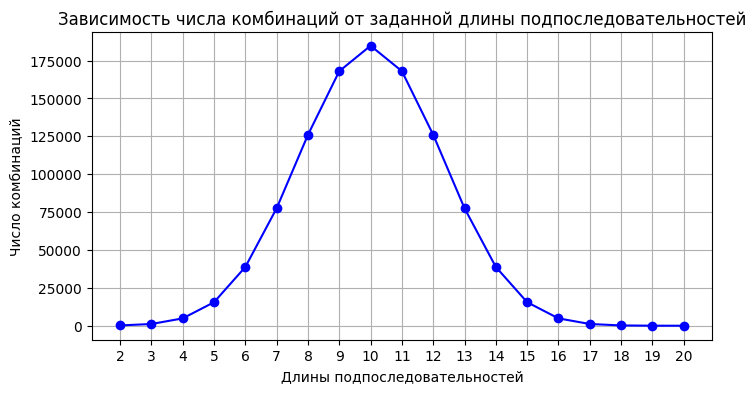

In [9]:
get_comb_report(data_pilotes_2_4)

...нам предстоит осуществить предварительный отбор. Мы уже проделывали подобное в тетрадке `runs_report`: составляли выборку сетов по метрикам из отчетов, задавая пороговое значение (оптимальный вариант можно подобрать методом перебора, разумеется).

Мы будем обращаться непосредственно к общему массиву данных из отчетов для каждого алгоритма. Столбец `cnt` в получившейся таблице означает количество зафиксированных случаев преодоления моделями заданного порога метрики.

In [10]:
# Зададим порог отбора данных
threshold = 0.92

# Создадим словарь для подсчета
files_dict = dict.fromkeys(list(range(31)), 0)
# Пройдемся циклом по метаданным и посчитаем количество
# f1_test выше заданного порога для каждого набора данных
for i in range(runs_reports.shape[0]):
    for j in range(runs_reports.shape[1]):
        if runs_reports[i, j, 3] >= threshold:
            files_dict[j] += 1
            
# Сформируем таблицу
files_df = pd.DataFrame(
        data=np.hstack((
            fils.reshape(-1, 1),
            pilotes.reshape(-1, 1),
            np.array(list(files_dict.values())).reshape(-1, 1)
            )),
        columns=[
            'file', 'pilote_id','cnt'
        ]
    )
# Выведем список лучших данных
best_files_for_pilotes_2_4 = files_df.query("cnt != 0 and pilote_id in [2, 4]")
print(f'При пороге отбора {threshold} (F1-weighted)')
print(f'Число файлов в исходной выборке: {len(data_pilotes_2_4)}')
print(f'Число годных файлов с данными: {best_files_for_pilotes_2_4.shape[0]}')
best_files_for_pilotes_2_4

При пороге отбора 0.92 (F1-weighted)
Число файлов в исходной выборке: 20
Число годных файлов с данными: 7


,file,pilote_id,cnt
8,2023-09-29_11-03-50,2,1
9,2023-09-29_09-20-47,2,5
12,2023-09-12_12-55-22,2,1
16,2023-05-22_17-04-29,2,5
17,2023-05-19_12-04-02,2,1
22,2023-05-05_17-57-30,4,5
28,2023-10-23_10-11-45,2,5


Число рассматриваемых сетов удалось существенно сократить.

Общее число комбинаций: 120


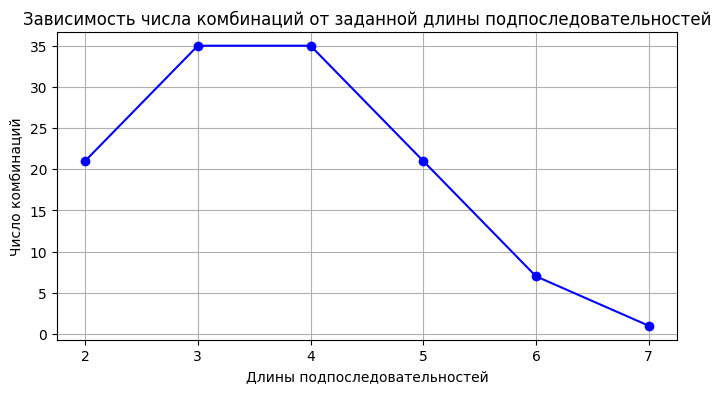

In [11]:
# Обновленный список
data_pilotes_2_4_new = best_files_for_pilotes_2_4.index.to_list()
# Данные пилотов 2 и 4
get_comb_report(data_pilotes_2_4_new)

Результат выглядит вполне удовлетворительным. Посмотрим на состояние двух других сборок.

Общее число комбинаций: 247


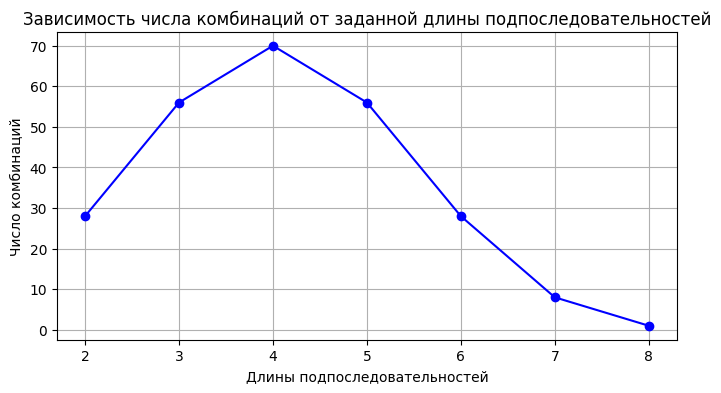

In [12]:
# Данные пилотов 1 и 4
get_comb_report(data_pilotes_1_4)

Как видим, не мешает отбросить несколько сетов первого пилота. Сделаем мы это несколько иным образом: настроим логический фильтр на отбор по метрикам трех жестов — Pistol, Thumb и OK. Порог будет задан именно для них, а не для средневзвешенного значения F1. Такой метод отбора позволит выбрать наиболее сбалансированные сеты.

In [13]:
# Зададим порог отбора данных
threshold = 0.35

# Создадим словарь для подсчета
files_dict = dict.fromkeys(list(range(31)), 0)
# Пройдемся циклом по метаданным
for i in range(runs_reports.shape[0]):
    for j in range(runs_reports.shape[1]):
        if (runs_reports[i, j, 6] >= threshold) and \
            (runs_reports[i, j, 7] >= threshold) and \
                (runs_reports[i, j, 8] >= threshold):
            files_dict[j] += 1
            
# Сформируем таблицу
files_df = pd.DataFrame(
        data=np.hstack((
            fils.reshape(-1, 1),
            pilotes.reshape(-1, 1),
            np.array(list(files_dict.values())).reshape(-1, 1)
            )),
        columns=[
            'file', 'pilote_id','cnt'
        ]
    )
# Выведем список лучших данных
best_files_for_pilotes_1_4 = files_df.query("cnt != 0 and pilote_id in [1, 4]")
print(f'При пороге отбора {threshold} (F1-weighted)')
print(f'Число файлов в исходной выборке: {len(data_pilotes_1_4)}')
print(f'Число годных файлов с данными: {best_files_for_pilotes_1_4.shape[0]}')
best_files_for_pilotes_1_4

При пороге отбора 0.35 (F1-weighted)
Число файлов в исходной выборке: 8
Число годных файлов с данными: 5


,file,pilote_id,cnt
0,2023-05-15_16-16-08,1,1
3,2023-06-05_17-53-01,1,4
4,2023-06-20_14-43-11,1,4
5,2023-06-20_13-30-15,1,11
22,2023-05-05_17-57-30,4,19


В отчете для заданного выше при выводе `report` алгоритма МО это будет следующая выборка:

In [14]:
# Разукрасим таблицуу для облегчения восприятия
report.loc[list(best_files_for_pilotes_1_4.index)].style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(report.columns)[2:]
)

,file,pilote_id,Corr,corr_a,corr_b,f1_test,Neutral,Open,Pistol,Thumb,OK,Grab
0,2023-05-15_16-16-08,1,0.274356,0.412871,0.256877,0.833128,0.902053,0.919192,0.641727,0.307978,0.779570,0.897368
3,2023-06-05_17-53-01,1,0.353172,0.264307,0.413203,0.746547,0.834416,0.785276,0.680973,0.373757,0.643200,0.644118
4,2023-06-20_14-43-11,1,0.083280,0.179436,0.182742,0.703648,0.811977,0.809892,0.452763,0.321569,0.633562,0.545151
5,2023-06-20_13-30-15,1,0.274443,0.235754,0.382149,0.753380,0.823946,0.830688,0.416510,0.519573,0.748538,0.776642
22,2023-05-05_17-57-30,4,0.353636,0.411456,0.330341,0.929161,0.945354,0.923077,0.925342,0.825455,0.915085,0.940933


Осталось обновить список отобранных сетов и посмотреть на распределение числа комбинаций для каждой длины подпоследовательности.

Общее число комбинаций: 26


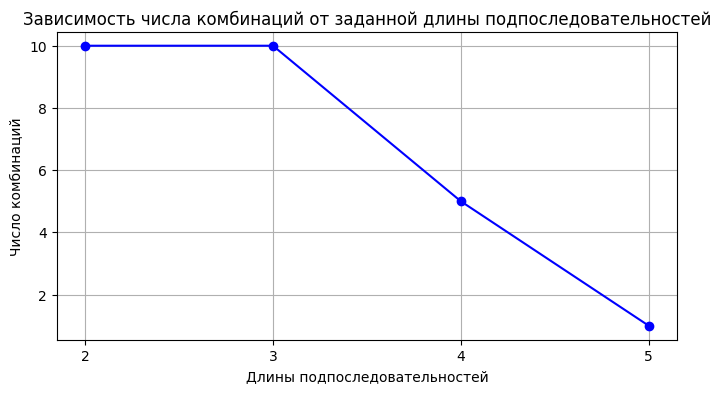

In [15]:
# Обновленный список
data_pilotes_1_4_new = best_files_for_pilotes_1_4.index.to_list()
# Данные пилотов 2 и 4
get_comb_report(data_pilotes_1_4_new)

И то же самое выведем уже для набора сетов для третьего с четвертым пилотов.

In [16]:
# Данные пилотов 3 и 4
get_comb_report(data_pilotes_3_4, plot=False)

Общее число комбинаций: 26


Т.к. объем выборки на этот раз тот же, число комбианций и график зависимости будут такими же — т.е. выводить последний нет смысла.

### Сборка и тестирование данных

Теперь, когда отбор сетов в наборы завершен, можно приступать к сборке скомбинированных данных.

In [17]:
def data_build(sets_idx_list):
    """Функция для получения сэмплов из объединенных данных

    Args:
        sets_idx_list (list): список индексов файлов
        в таблице метаданных.

    Returns:
        tuple: кортеж сэмплов вида:
            train_X, test_X, tran_y, test_y
    """
    le = preprocessing.LabelEncoder()
    total_train_data, total_test_data = np.zeros((0, 56)), np.zeros((0, 56))
    total_train_target, total_test_target = np.zeros(0), np.zeros(0)
    protocol_features = [
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]
    
    for data_idx in sets_idx_list:
        palm_file = './data/data_from_4_pilots/' + df_meta.loc[data_idx]['montage']
        data = read_omg_csv(
            palm_file, 
            n_omg_channels=50,
            n_acc_channels=3, 
            n_gyr_channels=3, 
            n_enc_channels=6, 
            n_mag_channels=0
        )
        
        protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
        # FIT
        le.fit(
            protocol[protocol_features]
            .apply(lambda row: str(tuple(row)), axis=1)
        )
        # TRANSFORM
        protocol['gesture'] = le.transform(
            protocol[protocol_features]
            .apply(lambda row: str(tuple(row)), axis=1)
        )
        
        target = np.array([protocol['gesture'].loc[s] for s in data['SYNC'].values])
        
        data = data.iloc[:, :56]

        target_shifted, _ = get_naive_centering(data.values, target, inter=1000, window=30, use_m=False)
        
        last_train_idx = df_meta[
            df_meta['montage'] == palm_file.split('/')[-1]
            ].to_dict(orient='records')[0]['last_train_idx']
        
        total_train_data = np.vstack((total_train_data, data[:last_train_idx].values))
        total_test_data = np.vstack((total_test_data, data[last_train_idx:].values))
        
        total_train_target = np.concatenate((total_train_target, target_shifted[:last_train_idx]))
        total_test_target = np.concatenate((total_test_target, target_shifted[last_train_idx:]))
    
    results_tuple = (total_train_data, total_test_data, total_train_target, total_test_target)
    
    return results_tuple

Функция выше нужна для непосредственного получения тест и трейн сэмплов — она будет работать на каждой итерации (для каждого набора отобранных ранее сетов) следующей функции.

In [18]:
def get_combined_data(list_of_sets, model=None, init_length=2):
    """Функция для получения массива подсчитанных метрик.

    Args:
        list_of_sets (_type_): список индексов сетов 
        (индексы строк в таблице метаданных).
        model (optional): обучаемый алгоритм МО. Defaults to None.
        По умолчанию используется логистическая регрессия.
        init_length (int, optional): начальная длина подпоследовательностей.

    Returns:
        touple:
            list: список составных индексов;
            ndarray: массив метрик f1: на первом столбце находятся weighted-значения,
            на оставшихся — значения метрики для каждого жеста в порядке,
            соответствующем списку GESTURES.
    """
    
    report = []
    index = []

    for r in range(init_length, len(list_of_sets)+1):
        for comb in tqdm([*combinations(list_of_sets, r)], desc="Processed"):
            row = []
            index.append('_'.join([str(n) for n in comb]))
            X_train, X_test, y_train, y_test = data_build(comb)
            
            if model is None:
                model = linear_model.LogisticRegression(
                    max_iter=10000, random_state=42, solver='liblinear'
                )
            model.fit(X_train, y_train)
            test_preds = model.predict(X_test)
            f1 = metrics.f1_score(y_test, test_preds, average='weighted')
            row.append(f1)
            
            for i in range(6):
                f1_test = metrics.f1_score(y_test, test_preds, average=None)[i]
                row.append(f1_test)
            
            report.append(np.array(row))
    
    return index, np.array(report)

Для получения массива метрик для отобранных сетов мы воспользуемся уже составленным ранее списком алгоритмов МО.

In [19]:
model = loaded_list_of_models[-1]
model

Мы выбрали алгоритм CatBoost — не самый быстрый вариант, но безусловно источник одних из самых качественных моделей.

In [86]:
# idx_list, data_pilotes_1_4_ndarray = get_combined_data(
#     data_pilotes_1_4_new, model=model
# )

Processed: 100%|██████████| 1/1 [00:43<00:00, 43.26s/it]


In [20]:
# Составим датафрейм из полученного массива
# data_pilotes_1_4_report_df = pd.DataFrame(
#     data_pilotes_1_4_ndarray, columns=['weighted F1', *GESTURES]
# )

# Добавим столбец с индексами сетов
# data_pilotes_1_4_report_df['comb'] = idx_list

# Сохранение датафрейма в CSV файл
# data_pilotes_1_4_report_df.to_csv('derivatives/data_pilotes_1_4_report_df.csv', index=False)

# Выгрузим датафрейм
data_pilotes_1_4_report_df = pd.read_csv('derivatives/data_pilotes_1_4_report_df.csv')

# Разукрасим таблицуу для облегчения восприятия
data_pilotes_1_4_report_df.style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(data_pilotes_1_4_report_df.columns[:-1])
)

,weighted F1,Neutral,Open,Pistol,Thumb,OK,Grab,comb
0,0.785415,0.863731,0.823025,0.657064,0.284623,0.740169,0.796089,0_3
1,0.795310,0.869911,0.872828,0.606061,0.398968,0.749112,0.750913,0_4
2,0.793271,0.860486,0.800745,0.597264,0.424825,0.781421,0.828829,0_5
3,0.877617,0.913697,0.927252,0.811559,0.612832,0.843823,0.904126,0_22
4,0.734431,0.819044,0.766732,0.603059,0.400000,0.682081,0.634299,3_4
5,0.741956,0.811736,0.740325,0.581685,0.401559,0.743312,0.766184,3_5
6,0.843088,0.879607,0.866704,0.776051,0.646720,0.828358,0.841907,3_22
7,0.742386,0.816064,0.744060,0.546211,0.510526,0.739229,0.665623,4_5
8,0.840406,0.880645,0.886447,0.778357,0.658365,0.806701,0.787412,4_22
9,0.844768,0.876152,0.832476,0.759247,0.693467,0.855263,0.865196,5_22


Весьма неплохо получилось совместить данные с первого сета (нулевой индекс) первого пилота с данными четвертого. Однако, как видим, чем больше число комбинируемых сетов, тем хуже становится качество предсказаний. Но в целом результаты приемлемы: худший результат — 0.74.

Выберем наилучшие комбинации.

In [21]:
mask = data_pilotes_1_4_report_df['weighted F1'] > 0.84

data_pilotes_1_4_report_df[mask].style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(data_pilotes_1_4_report_df.columns[:-1])
)

,weighted F1,Neutral,Open,Pistol,Thumb,OK,Grab,comb
3,0.877617,0.913697,0.927252,0.811559,0.612832,0.843823,0.904126,0_22
6,0.843088,0.879607,0.866704,0.776051,0.646720,0.828358,0.841907,3_22
8,0.840406,0.880645,0.886447,0.778357,0.658365,0.806701,0.787412,4_22
9,0.844768,0.876152,0.832476,0.759247,0.693467,0.855263,0.865196,5_22
15,0.841926,0.885080,0.858487,0.733154,0.591681,0.822368,0.875000,0_5_22


Перейдем к рассмотрению наборов для пары третьего и четвертого пилотов.

In [89]:
# Получим массив данных
# idx_list, data_pilotes_3_4_ndarray = get_combined_data(
#     data_pilotes_3_4, model=model
# )

# Составим датафрейм из полученного массива
# data_pilotes_3_4_report_df = pd.DataFrame(
#     data_pilotes_3_4_ndarray, columns=['weighted F1', *GESTURES]
# )

# # Добавим столбец с индексами сетов
# data_pilotes_3_4_report_df['comb'] = idx_list

# Сохранение датафрейма в CSV файл
# data_pilotes_3_4_report_df.to_csv('derivatives/data_pilotes_3_4_report_df.csv', index=False)

Processed: 100%|██████████| 1/1 [00:36<00:00, 36.54s/it]


In [22]:
# Выгрузим датафрейм
data_pilotes_3_4_report_df = pd.read_csv('derivatives/data_pilotes_3_4_report_df.csv')

В этой паре результаты будут получше. Даже комбинация из пяти сетов получилась вполне сносной. Но мы попробуем выбрать наилучшие комбинации.

In [23]:
mask = data_pilotes_3_4_report_df['weighted F1'] > 0.89

data_pilotes_3_4_report_df[mask].style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(data_pilotes_3_4_report_df.columns[:-1])
)

,weighted F1,Neutral,Open,Pistol,Thumb,OK,Grab,comb
3,0.903182,0.930411,0.872483,0.907026,0.715412,0.900181,0.927853,18_22
8,0.905813,0.934877,0.937500,0.911565,0.686243,0.879872,0.907975,20_22
14,0.892947,0.927041,0.878719,0.892353,0.664434,0.867863,0.920801,18_20_22
19,0.892756,0.923326,0.886513,0.864440,0.733418,0.852352,0.911635,20_21_22


И, наконец, рассмотрим наборы для пары второго и четвертого пилотов.

In [92]:
# Прогоням наборы данных через алгоритм
# idx_list, data_pilotes_2_4_ndarray = get_combined_data(
#     data_pilotes_2_4_new, model=model
# )

# Составим датафрейм из полученного массива
# data_pilotes_2_4_report_df = pd.DataFrame(
#     data_pilotes_2_4_ndarray, columns=['weighted F1', *GESTURES]
# )

# Добавим столбец с индексами сетов
# data_pilotes_2_4_report_df['comb'] = idx_list

# Сохранение датафрейма в CSV файл
# data_pilotes_2_4_report_df.to_csv('derivatives/data_pilotes_2_4_report_df.csv', index=False)

Processed: 100%|██████████| 1/1 [00:43<00:00, 43.23s/it]


In [24]:
# Выгрузим датафрейм
data_pilotes_2_4_report_df = pd.read_csv('derivatives/data_pilotes_2_4_report_df.csv')

Выводить 120 строк было бы излишним, поэтому здесь также применим фильтр.

In [25]:
mask = data_pilotes_2_4_report_df['weighted F1'] > 0.917

data_pilotes_2_4_report_df[mask].style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(data_pilotes_2_4_report_df.columns[:-1])
)

,weighted F1,Neutral,Open,Pistol,Thumb,OK,Grab,comb
0,0.918110,0.933582,0.911378,0.906904,0.926293,0.835917,0.901939,8_9
7,0.921168,0.942279,0.884032,0.871618,0.921708,0.880184,0.882096,9_16
16,0.922517,0.944688,0.921811,0.875521,0.846469,0.877173,0.914943,16_22
22,0.921022,0.938821,0.902527,0.881098,0.927147,0.865014,0.894695,8_9_16
23,0.917168,0.939773,0.910312,0.884440,0.909720,0.815312,0.894531,8_9_17
25,0.917649,0.935167,0.887574,0.904519,0.914329,0.855849,0.903737,8_9_28
41,0.918858,0.942023,0.915423,0.873282,0.874121,0.859341,0.895511,9_16_22
61,0.918246,0.938175,0.910417,0.896959,0.875164,0.860265,0.899220,8_9_16_22
62,0.919108,0.938927,0.892586,0.892185,0.914806,0.846517,0.902251,8_9_16_28


Итак, пожалуй, нам удалось отобрать совместимые с данными четвертого пилота сеты остальных трех пилотов. Далее мы поступим аналогичным образом: составим список индексов отобранных сетов и запустим уже знакомый нам код для перебора комбинаций. С единственным отличием — минимальная длина подпоследовательностей теперь будет 4, т.к. нас интересует возможность создания общей, генеральной, модели, а не возможность обучить общую для двух или трех пилотов модель.

Общее число комбинаций: 64


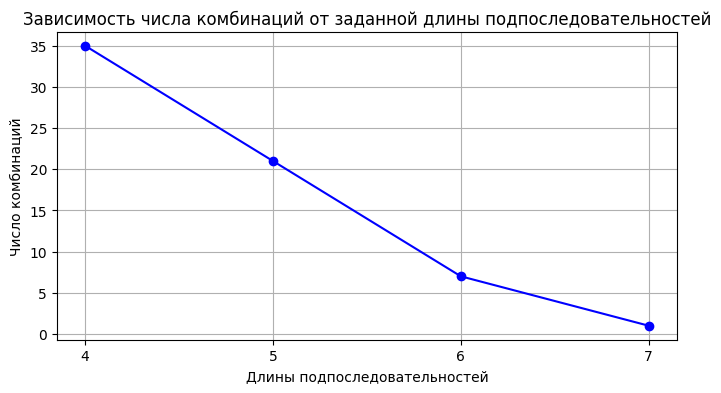

In [26]:
# Создадим список индексов сетов, слегка чередуя порядок
data_pilotes_1_2_3_4 = [0, 9, 18, 5, 16, 20, 22]

# Оценим пространство комбинаций
get_comb_report(data_pilotes_1_2_3_4, init_length=4)

У нас в итоге осталось по два сета на каждого пилота, кроме четвертого. Число комбинаций не такое уж большое, можем начать исследование выбранных сетов на возможность обучения генеральной модели.

In [97]:
# Прогоням наборы данных через алгоритм
# idx_list, data_pilotes_1_2_3_4_ndarray = get_combined_data(
#     data_pilotes_1_2_3_4, model=model, init_length=4
# )

# Составим датафрейм из полученного массива
# data_pilotes_1_2_3_4_report_df = pd.DataFrame(
#     data_pilotes_1_2_3_4_ndarray, columns=['weighted F1', *GESTURES]
# )

# Добавим столбец с индексами сетов
# data_pilotes_1_2_3_4_report_df['comb'] = idx_list

Processed: 100%|██████████| 1/1 [00:55<00:00, 55.71s/it]


Также сохраним получившийся результат.

In [27]:
# Сохранение датафрейма в CSV файл
# data_pilotes_1_2_3_4_report_df.to_csv('derivatives/data_pilotes_1_2_3_4_report_df.csv', index=False)

# Выгрузим датафрейм
data_pilotes_1_2_3_4_report_df = pd.read_csv('derivatives/data_pilotes_1_2_3_4_report_df.csv')

И нас снова интересуют лишь лучшие результаты.

In [28]:
mask = data_pilotes_1_2_3_4_report_df['weighted F1'] > 0.89
data_pilotes_1_2_3_4_report_df[mask].style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(data_pilotes_1_2_3_4_report_df.columns[:-1])
)

,weighted F1,Neutral,Open,Pistol,Thumb,OK,Grab,comb
1,0.890415,0.924901,0.846549,0.855967,0.711948,0.870506,0.896438,0_9_18_16
8,0.901290,0.930228,0.911765,0.836947,0.772022,0.861412,0.894753,0_9_16_22
14,0.895391,0.927428,0.880022,0.853716,0.710776,0.871478,0.908848,0_18_16_22
23,0.896119,0.929965,0.848681,0.873796,0.748926,0.855061,0.903475,9_18_16_20
24,0.904583,0.931353,0.871795,0.891695,0.787711,0.864893,0.907302,9_18_16_22
25,0.892994,0.925836,0.881622,0.873804,0.715986,0.847474,0.915246,9_18_20_22
29,0.904397,0.932362,0.912471,0.876392,0.794451,0.837222,0.892497,9_16_20_22
33,0.895372,0.930937,0.881886,0.866896,0.707291,0.849832,0.906507,18_16_20_22
39,0.896103,0.927204,0.869740,0.857143,0.737917,0.867151,0.909130,0_9_18_16_22
44,0.893434,0.927326,0.912924,0.838932,0.707994,0.848527,0.896599,0_9_16_20_22


Как видим, обучить приемлемую генеральную модель на данных всех четырех пилотов все же возможно. Однако на это пригодны далеко не все сеты.

Далее мы попробуем улучшить результаты генеральных моделей, обученных как для каждого пилота, так и для всех.

---
## Сэмплирование данных

Сперва необходимо определить списки индексов сетов для каждого пилота, а также список индексов для обучения общей для всех пилотов модели.

Именно от выбора индексов сетов в данном этапе зависит все дальнейшее решение в ноутбуке. Можно указать любые индексы — все или специально отобранные. В данном случае, ниже, собраны наборы из сетов, которые, на первый взгляд, позволяют обучить качественные модели (т.е. предполагается возможным оспорить любой из пулов).

In [48]:
# first_pilot_data_idx = [0, 4, 5]
# second_pilot_data_idx = [9, 16, 17, 28]
# third_pilot_data_idx = [18, 20, 21]
# fourth_pilot_data_idx = [22]
# general_model_data_idx = [0, 16, 18, 22]

Далее все проще — получить соответствующе сэмплы из наборов и собрать их в словари, которые в следующем разделе будут дополнятся вариантами данных, прошедших разные способы предобработки и генерации признаков.

In [49]:
# Создаем словари
# first_pilot_dict = {}
# second_pilot_dict = {}
# third_pilot_dict = {}
# fourth_pilot_dict = {}
# general_model_dict = {}


# Извлекаем сэмплы из наборов данных и помещаем
# их в словари под соответствующими ключами
# first_pilot_dict['first_pilot_data'] = data_build(first_pilot_data_idx)
# second_pilot_dict['second_pilot_data'] = data_build(second_pilot_data_idx)
# third_pilot_dict['third_pilot_data'] = data_build(third_pilot_data_idx)
# fourth_pilot_dict['fourth_pilot_data'] = data_build(fourth_pilot_data_idx)
# general_model_dict['general_model_data'] = data_build(general_model_data_idx)

И можем посмотреть, как все получилось:

In [50]:
# dictionaries = [
#     first_pilot_dict, second_pilot_dict, third_pilot_dict,
#     fourth_pilot_dict, general_model_dict
# ]

# for dictionary in dictionaries:
#     for key in list(dictionary.keys()):
#         print(f"{str(key).capitalize().replace('_', ' ')} shapes:")
#         print('Train:', dictionary[key][0].shape, dictionary[key][2].shape)
#         print('Test: ', dictionary[key][1].shape, dictionary[key][3].shape)
#         print()

First pilot data shapes:
Train: (59201, 56) (59201,)
Test:  (14680, 56) (14680,)

Second pilot data shapes:
Train: (57953, 56) (57953,)
Test:  (22588, 56) (22588,)

Third pilot data shapes:
Train: (48399, 56) (48399,)
Test:  (17289, 56) (17289,)

Fourth pilot data shapes:
Train: (20756, 56) (20756,)
Test:  (5892, 56) (5892,)

General model data shapes:
Train: (96914, 56) (96914,)
Test:  (25570, 56) (25570,)



56 признаков в данных в себя включают: данные из ОМГ-датчиков (50 колонок), данные акселерометра и гироскопа (по 3 колонки).

---
## Предобработка данных и генерация признаков

В этом разделе мы попробуем несколько улучшить качество предсказаний моделей. Характеристиками baseline-решения в данном случае будут выступать метрики рассчитанные в предыдущих разделах.


### Оценка доли нулей

В этом подразделе осуществляется визуализация нулевых строк в данных и подсчет их доли в признаках. Это может быть полезным, если мы желаем предварительно оценить вклад признаков в предсказания обучаемых моделей. Например, следующая картина может быть очень даже любопытной.

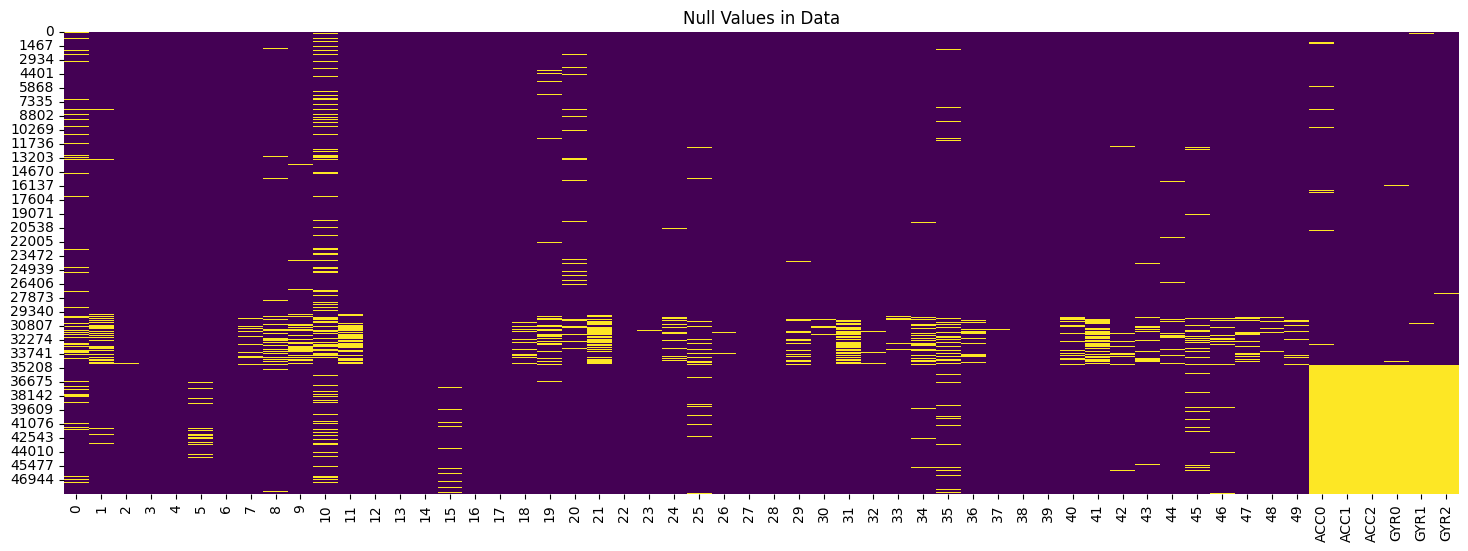

In [51]:
# null_detect = pd.DataFrame(
#     third_pilot_dict['third_pilot_data'][0],
#     columns=[*OMG_CH, *ACC_CH, *GYR_CH]
# ).replace(0, np.nan)

# Создадим тепловую карту для визуализации 0-значений
# plt.figure(figsize=(18, 6))
# sns.heatmap(null_detect.isna(), cbar=False, cmap='viridis')
# plt.title('Null Values in Data')
# plt.show()

Нетрудно выяснить индекс сета (21-й) из набора третьего пилота, который, видимо, был записан без показаний акселерометра и гироскопа. 20-й сет тоже имеет довольно любопытную частоту *нулевого населения* в нескольких столбцах.

In [52]:
# cols_null_persent = null_detect.isna().mean() * 100
# cols_with_null = cols_null_persent[cols_null_persent>0].sort_values(ascending=False)
# cols_with_null[:10]

ACC0    29.174156
GYR0    28.391082
GYR2    28.136945
GYR1    28.052232
ACC1    27.955123
ACC2    27.915866
10      23.855865
0       13.739953
1        7.717102
9        6.977417
dtype: float64

### Функция визуализации

In [29]:
def get_graphs(X_array, y_array, start=1000, end=1500):
    """Функция для отрисовки графики "OMG and Protocol"
    для заданного интервала

    Args:
        X_array (ndarray): массив данных.
        y_array (ndarray): вектор таргета.
        start (int, optional): стартовая точка данных
        визуализируемого интервала. Defaults to 1000.
        end (int, optional): конечная точка данных
        визуализируемого интервала. Defaults to 1500.
    """
    
    _, ax1 = plt.subplots(sharex=True, figsize=(12, 4))
    plt.suptitle(f'OMG and Protocol {start}:{end}')
    ax1.plot(X_array[start:end])
    ax1.set_xlabel('Timesteps')
    ax1.set_ylabel('OMG')
    plt.grid(axis='x')
    ax2 = ax1.twinx()
    ax2.plot(y_array[start:end], 'b-')
    ax2.set_ylabel('y_cmd')
    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.show()

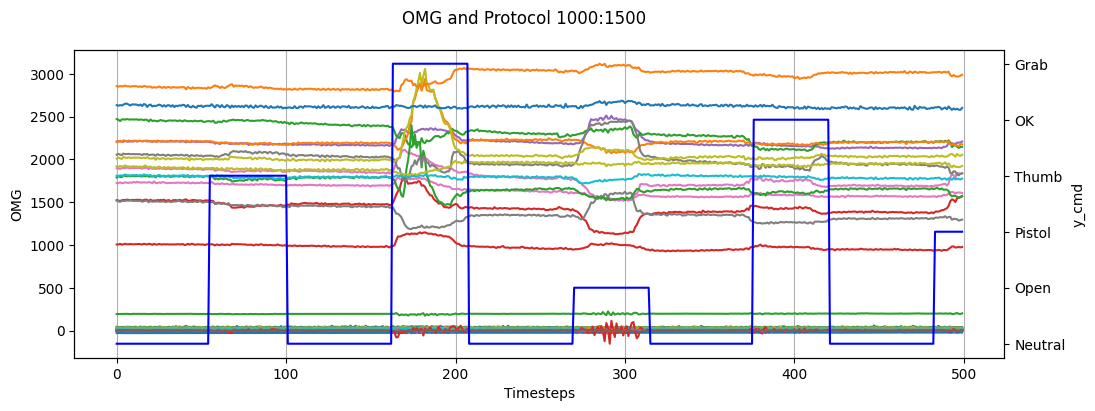

In [54]:
# X_train = first_pilot_dict[list(first_pilot_dict.keys())[0]][0]
# y_train = first_pilot_dict[list(first_pilot_dict.keys())[0]][2]

# get_graphs(X_train, y_train, start=1000, end=1500)

### Нормализация и стандартизация

Мы могли бы рассмотреть столько же способов нормализации данных, сколько рассмотрели в тетрадке `solving_the_test_task`, но это сильно скажется на приросте времени, которое необходимо будет затратить даже для генерации признаков, а уж на этапе прогона данных по моделям...

In [55]:
# Инициализируем методы нормализации и стандартизации
# mm_scaler = preprocessing.MinMaxScaler()
# st_scaler = preprocessing.StandardScaler()

# Занесем в каждый словарь предобработанные версии данных
# for dictionary in dictionaries:
#     for key in list(dictionary.keys()):
#         train_y = dictionary[key][2]
#         test_y = dictionary[key][3]
        
#         X_train_mm = mm_scaler.fit_transform(dictionary[key][0])
#         X_test_mm = mm_scaler.transform(dictionary[key][1])
        
#         dictionary['mm_samples'] = (X_train_mm, X_test_mm, train_y, test_y)
        
#         X_train_st = st_scaler.fit_transform(dictionary[key][0])
#         X_test_st = st_scaler.transform(dictionary[key][1])
        
#         dictionary['st_samples'] = (X_train_st, X_test_st, train_y, test_y)

In [56]:
# for dictionary in dictionaries:
#     print(dictionary.keys())

dict_keys(['first_pilot_data', 'mm_samples', 'st_samples'])
dict_keys(['second_pilot_data', 'mm_samples', 'st_samples'])
dict_keys(['third_pilot_data', 'mm_samples', 'st_samples'])
dict_keys(['fourth_pilot_data', 'mm_samples', 'st_samples'])
dict_keys(['general_model_data', 'mm_samples', 'st_samples'])


### Генерация признаков
#### Аппроксимирующая модель линейной регрессии

In [30]:
def get_approx_lr_coefs(X, n_ftrs=10, prev=None, lin_alg=None):
    """Функция для формирования признакового описания 
       с использованием линейной регрессии

    Args:
        X (ndarray): массив данных.
        n_ftrs (int, optional): размер сэмпла. Defaults to 10.
        prev (ndarray, optional): предшествующие данные размером n_ftrs.
        Defaults to None.
        lin_alg (abc.ABCMeta, optional): линейный алгоритм sklearn.
        По умолчанию используется алгоритм МНК из numpy.

    Returns:
        ndarray: массив коэффициентов модели регрессии.
    """
    
    def get_coefs(data):
        # Разделение данных на признаки и целевую переменную
        segments_X = data[1:, :].T
        segments_y = data[0, :]
        
        # Обучение модели линейной регрессии
        if lin_alg is not None:
            model = lin_alg()
            model.fit(segments_X, segments_y)
            # Получение параметров модели
            return model.coef_
        else:
            w = np.linalg.lstsq(segments_X, segments_y, rcond=None)[0]
            # Вектор весов линейной функции
            return w
        
    
    w_g = np.zeros((0, n_ftrs))
    window = np.zeros((n_ftrs+1, X.shape[-1]))
    if prev is not None:
        window[1:, :] = prev
    
    for i in range(X.shape[0]):
        if not np.sum(window[0]):
            window[0, :] = X[i]
        else:
            window[1:, :] = window[:-1, :]
            window[0, :] = X[i]

        coefs = get_coefs(window)
        w_g = np.vstack((w_g, coefs))
    
    return w_g

Сгенерируем новые сэмплы.

In [58]:
# Занесем в каждый словарь предобработанные версии данных
# for dictionary in dictionaries:
#     for key in tqdm(list(dictionary.keys()), desc="Processed"):
#         train_y = dictionary[key][2]
#         test_y = dictionary[key][3]
        
#         X_train_ax = get_approx_lr_coefs(dictionary[key][0])
#         X_test_ax = get_approx_lr_coefs(dictionary[key][1])
        
#         new_key = key + '_ax'
#         dictionary[new_key] = (X_train_ax, X_test_ax, train_y, test_y)

Processed: 100%|██████████| 3/3 [03:57<00:00, 79.25s/it]


In [59]:
# for dictionary in dictionaries:
#     print(list(dictionary.keys())[:-3])
#     print(list(dictionary.keys())[-3:])

['first_pilot_data', 'mm_samples', 'st_samples']
['first_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['second_pilot_data', 'mm_samples', 'st_samples']
['second_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['third_pilot_data', 'mm_samples', 'st_samples']
['third_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['fourth_pilot_data', 'mm_samples', 'st_samples']
['fourth_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['general_model_data', 'mm_samples', 'st_samples']
['general_model_data_ax', 'mm_samples_ax', 'st_samples_ax']


#### Аппроксимирующая модель авторегрессии

In [31]:
def get_ar_coefs(array, p=5, prev=None):
    """Функция для генерации новых признаков на основе векторов
    оптимальных параметров модели авторегрессии.

    Args:
        array (ndarray): массив данных.
        p (int, optional): размер базы аппроксимации. Defaults to 5.
        prev (ndarray): массив данных для аппроксимации первой точки.
        Defaults to None.

    Returns:
        ndarray: массив сгенерированных признаков на основе
        рассчитанных коэффициентов.
    """
    new_features = np.zeros((array.shape[0],0))
    
    # Проходим внешним циклом по переменным (столбцам) в данных
    for i in range(array.shape[1]):
        if prev is None:
            data = np.hstack((np.zeros(p), array[:, i]))
        else:
            data = np.hstack((prev[:, i], array[:, i]))
        t = len(data)
        w_massive = np.zeros((0, p+1))
        
        # Проходим внутренним циклом по вектору значений переменного
        for j in range(p, t):
            features = data[j-p:j]
            labels = np.array(data[j]).reshape(-1, 1)
        
            # Решение системы уравнений методом наименьших квадратов
            X = np.hstack((np.ones(1), features)).reshape(1, -1)
            w = np.linalg.lstsq(X, labels, rcond=None)[0]
            
            w_massive = np.vstack((w_massive, w.reshape(1, -1)))
            
        # Собираем в единый массив параметры МНК
        new_features = np.hstack((new_features, w_massive))
        
    return new_features

Добавим новые сэмплы.

In [61]:
# Занесем в каждый словарь предобработанные версии данных
# for dictionary in dictionaries:
#     for key in tqdm(list(dictionary.keys())[:3], desc="Processed"):
#         train_y = dictionary[key][2]
#         test_y = dictionary[key][3]
        
#         X_train_ar = get_ar_coefs(dictionary[key][0])
#         X_test_ar = get_ar_coefs(dictionary[key][1])
        
#         new_key = key + '_ar'
#         dictionary[new_key] = (X_train_ar, X_test_ar, train_y, test_y)

Processed: 100%|██████████| 3/3 [2:09:49<00:00, 2596.55s/it]


Снова посмотрим на возросшую коллекцию ключей в словарях.

In [62]:
# for dictionary in dictionaries:
#     print(list(dictionary.keys())[:3])
#     print(list(dictionary.keys())[3:6])
#     print(list(dictionary.keys())[6:])

['first_pilot_data', 'mm_samples', 'st_samples']
['first_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['first_pilot_data_ar', 'mm_samples_ar', 'st_samples_ar']
['second_pilot_data', 'mm_samples', 'st_samples']
['second_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['second_pilot_data_ar', 'mm_samples_ar', 'st_samples_ar']
['third_pilot_data', 'mm_samples', 'st_samples']
['third_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['third_pilot_data_ar', 'mm_samples_ar', 'st_samples_ar']
['fourth_pilot_data', 'mm_samples', 'st_samples']
['fourth_pilot_data_ax', 'mm_samples_ax', 'st_samples_ax']
['fourth_pilot_data_ar', 'mm_samples_ar', 'st_samples_ar']
['general_model_data', 'mm_samples', 'st_samples']
['general_model_data_ax', 'mm_samples_ax', 'st_samples_ax']
['general_model_data_ar', 'mm_samples_ar', 'st_samples_ar']


### Резервная запись данных в файл

Т.к. процесс генерации признакового описания занял довольно большое время, целесообразно осуществить резервное хранение данных. В репозитории на гитхабе папки с резервными копиями не будет, т.к. получившиеся файлы весят в сумме 3.3 гигабайт. Однако привести код для подобных операций будет нелишним.

In [67]:
# Осуществляем копирование
# reserve_dictionaries_copy = dictionaries.copy()

# # Пишем функцию
# def dict2npy(dictionary, prefix=''):
#     """Функция для записи данных в файлы

#     Args:
#         dictionary (_type_): словарь с массивами.
#         name (str, optional): префикс для имени файла.
#         Defaults to ''.
#     """
    
#     folder_path = "data_reserve/"
    
#     train_X, test_X, = [], []
#     for key in list(dictionary.keys())[:3]:
#         train_y, test_y = dictionary[key][2], dictionary[key][3]
#         train_X.append(dictionary[key][0])
#         test_X.append(dictionary[key][1])
        
#     train_X_ax, test_X_ax, = [], []
#     for key in list(dictionary.keys())[3:6]:
#         train_X_ax.append(dictionary[key][0])
#         test_X_ax.append(dictionary[key][1])
        
#     train_X_ar, test_X_ar, = [], []
#     for key in list(dictionary.keys())[6:]:
#         train_X_ar.append(dictionary[key][0])
#         test_X_ar.append(dictionary[key][1])
    
#     np.save(f'data_reserve/{prefix+"_train_X"}.npy', np.array(train_X))
#     np.save(f'data_reserve/{prefix+"_train_X_ax"}.npy', np.array(train_X_ax))
#     np.save(f'data_reserve/{prefix+"_train_X_ar"}.npy', np.array(train_X_ar))
    
#     np.save(f'data_reserve/{prefix+"_test_X"}.npy', np.array(test_X))
#     np.save(f'data_reserve/{prefix+"_test_X_ax"}.npy', np.array(test_X_ax))
#     np.save(f'data_reserve/{prefix+"_test_X_ar"}.npy', np.array(test_X_ar))
    
#     np.save(f'data_reserve/{prefix+"_train_target"}.npy', np.array(train_y))
#     np.save(f'data_reserve/{prefix+"_test_target"}.npy', np.array(test_y))

In [68]:
# Запускаем генерацию файлов с данными
# dict2npy(reserve_dictionaries_copy[0], prefix='p1')
# dict2npy(reserve_dictionaries_copy[1], prefix='p2')
# dict2npy(reserve_dictionaries_copy[2], prefix='p3')
# dict2npy(reserve_dictionaries_copy[3], prefix='p4')
# dict2npy(reserve_dictionaries_copy[4], prefix='gm')

Сохранить данные в файлы — это, конечно, здорово, но сможем ли мы их считать обратно? Нам надо собрать словари из данных в файлах.

In [32]:
def npy2dict(prefix=None):
    """Функция для получения словаря из сохраненных ранее
    в файлы ndarray-массивов

    Args:
        prefix (str, optional): префикс имен файлов. Defaults to None.

    Returns:
        dict: словарь массивов.
    """
    
    if prefix is None:
        print('Префикс не задан!')
        return {}
    
    directory_path = "data_reserve/"
    file_names = os.listdir(directory_path)
    
    dictionary = {}
    files = []
    endings = ['', '_mm', '_st']
    
    for name in file_names:
        if name.startswith(prefix):
            files.append(name)
            
    for file_name in files:
        if file_name.endswith('train_X.npy'):
            for i in range(3):
                key = prefix + '_data' + endings[i]
                dictionary[key] = [np.load(directory_path + file_name)[i]]
    
    for file_name in files:  
        if file_name.endswith('test_X.npy'):
            for i, key in enumerate(list(dictionary.keys())):
                existing_list = dictionary[key]
                existing_list.append(np.load(directory_path + file_name)[i])
                
    for file_name in files:
        if file_name.endswith('train_X_ax.npy'):
            for i in range(3):
                key = prefix + '_data' + endings[i] + '_ax'
                dictionary[key] = [np.load(directory_path + file_name)[i]]
    
    for file_name in files:  
        if file_name.endswith('test_X_ax.npy'):
            for i, key in enumerate(list(dictionary.keys())[3:]):
                existing_list = dictionary[key]
                existing_list.append(np.load(directory_path + file_name)[i])
                
    for file_name in files:
        if file_name.endswith('train_X_ar.npy'):
            for i in range(3):
                key = prefix + '_data' + endings[i] + '_ar'
                dictionary[key] = [np.load(directory_path + file_name)[i]]
    
    for file_name in files:  
        if file_name.endswith('test_X_ar.npy'):
            for i, key in enumerate(list(dictionary.keys())[6:]):
                existing_list = dictionary[key]
                existing_list.append(np.load(directory_path + file_name)[i])
    
    for file_name in files:
        if file_name.endswith('train_target.npy'):
            for i, key in enumerate(list(dictionary.keys())):
                existing_list = dictionary[key]
                existing_list.append(np.load(directory_path + file_name))
    
    for file_name in files:
        if file_name.endswith('test_target.npy'):
            for i, key in enumerate(list(dictionary.keys())):
                existing_list = dictionary[key]
                existing_list.append(np.load(directory_path + file_name))
                
    return dictionary

Что-то многовато циклов. Несомненно, должны существовать оптимальные способы сокращения этого кода без функциональных потерь. Но для наших целей достаточно и имеющегося.

Получим же обратно наши словари:

In [33]:
first_pilot_loaded_dict = npy2dict(prefix='p1')
second_pilot_loaded_dict = npy2dict(prefix='p2')
third_pilot_loaded_dict = npy2dict(prefix='p3')
fourth_pilot_loaded_dict = npy2dict(prefix='p4')
gm_loaded_dict = npy2dict(prefix='gm')

# Соберем их снова в список
loaded_dictionaries = [
    first_pilot_loaded_dict, second_pilot_loaded_dict,
    third_pilot_loaded_dict, fourth_pilot_loaded_dict,
    gm_loaded_dict
]

Посмотрим на ключи.

In [34]:
for dictionary in loaded_dictionaries:
    print(list(dictionary.keys())[:3])
    print(list(dictionary.keys())[3:6])
    print(list(dictionary.keys())[6:])

['p1_data', 'p1_data_mm', 'p1_data_st']
['p1_data_ax', 'p1_data_mm_ax', 'p1_data_st_ax']
['p1_data_ar', 'p1_data_mm_ar', 'p1_data_st_ar']
['p2_data', 'p2_data_mm', 'p2_data_st']
['p2_data_ax', 'p2_data_mm_ax', 'p2_data_st_ax']
['p2_data_ar', 'p2_data_mm_ar', 'p2_data_st_ar']
['p3_data', 'p3_data_mm', 'p3_data_st']
['p3_data_ax', 'p3_data_mm_ax', 'p3_data_st_ax']
['p3_data_ar', 'p3_data_mm_ar', 'p3_data_st_ar']
['p4_data', 'p4_data_mm', 'p4_data_st']
['p4_data_ax', 'p4_data_mm_ax', 'p4_data_st_ax']
['p4_data_ar', 'p4_data_mm_ar', 'p4_data_st_ar']
['gm_data', 'gm_data_mm', 'gm_data_st']
['gm_data_ax', 'gm_data_mm_ax', 'gm_data_st_ax']
['gm_data_ar', 'gm_data_mm_ar', 'gm_data_st_ar']


### Комбинирование

Мы также составим различные комбинации данных.

In [35]:
# Занесем в каждый словарь предобработанные версии данных
for dictionary in tqdm(loaded_dictionaries, desc="Processed"):
    keys_list = list(dictionary.keys())
    train_y = dictionary[keys_list[0]][2]
    test_y = dictionary[keys_list[0]][3]
    
    key_prefix = keys_list[0][:2]

    for suffix, indices in [
        ('ax_', [0, 3]), ('ar_', [0, 6]),
        ('ax_ar', [3, 6]), ('ax_ar_', [0, 3, 6])
        ]:
        new_key = key_prefix + '_data_' + suffix
        X_train = np.hstack([dictionary[keys_list[i]][0] for i in indices])
        X_test = np.hstack([dictionary[keys_list[i]][1] for i in indices])
        dictionary[new_key] = [X_train, X_test, train_y, test_y]

Processed: 100%|██████████| 5/5 [00:07<00:00,  1.58s/it]


### Экспоненциальное сглаживаение

In [36]:
def get_convolve(data, M=10, tau=3, sym=True):
    """Функция для экспоненциального сглаживания с помощью
    оконных методов scipy.

    Args:
        data (ndarray): массив данных.
        M (int, optional): Количество точек в окне вывода. Defaults to 10.
        tau (int, optional): Параметр, определяющий затухание. Defaults to 3.
        sym (bool, optional): Если установлено значение True (по умолчанию),
        создается симметричное окно для использования при проектировании фильтра.
        Если значение равно False, генерирует периодическое окно для использования
        в спектральном анализе. Defaults to True.

    Returns:
        ndarray: преобразованный массив.
    """
    win = signal.windows.exponential(M, tau=tau, sym=sym)
    data_result = np.zeros((data.shape[0]))
    for i in range(data.shape[1]):
        sig = data[:, i]
        filtered = signal.convolve(sig, win, mode='same') / sum(win)
        data_result = np.column_stack((data_result, filtered))
        
    return data_result[:, 1:]

In [37]:
for dictionary in tqdm(loaded_dictionaries, desc="Processed"):
    keys_list = list(dictionary.keys())
    for key in keys_list:
        train_X, test_X, train_y, test_y = dictionary[key]
        train_X_ce = get_convolve(train_X, M=10, tau=1, sym=False)
        test_X_ce = get_convolve(test_X, M=10, tau=1, sym=False)
        key_ce = f'ce_{key}'
        dictionary[key_ce] = [train_X_ce, test_X_ce, train_y, test_y]

Processed: 100%|██████████| 5/5 [05:51<00:00, 70.31s/it]


Посмотрим на визуализацию одного из наборов данных.

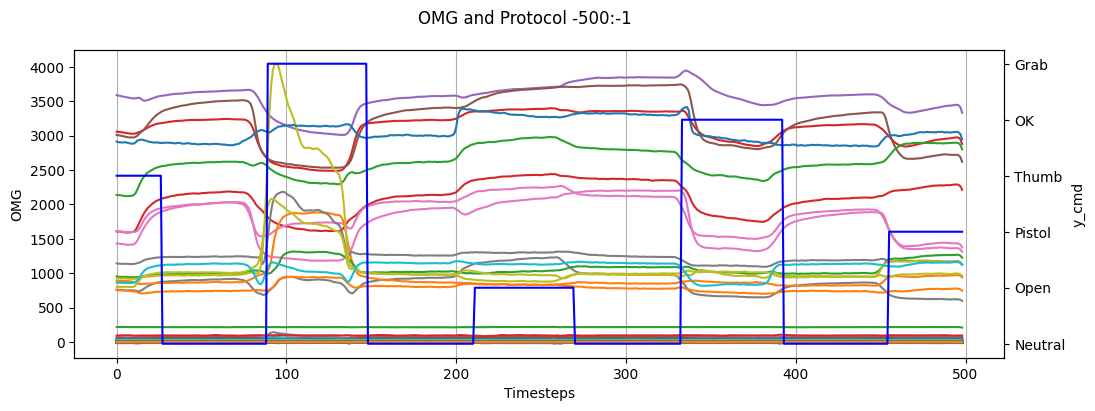

In [38]:
get_graphs(
    loaded_dictionaries[-1][list(loaded_dictionaries[-1].keys())[-1]][0],
    loaded_dictionaries[-1][list(loaded_dictionaries[-1].keys())[-1]][2],
    start=-500, end=-1
)

Также в целях экономии времени на этот раз мы не будем рассматривать другую функцию сглаживания и метод понижения размерности PCA. Это еще один момент, в котором можно было бы расширить исследование.

---
## Моделирование

### Отбор оптимальных моделей

На этот раз мы будем испытывать лишь один алгоритм — CatBoostClassifier, т.к. обучение 20 моделей, как мы это делали в ноутбуке `solving_the_test_task`, в данном случае заняло бы куда больше времени, также чрезмерную трату ресурсов теперь оправдать сложнее.

Мы, конечно, можем использовать любой алгоритм из уже рассмотренных, но CatBoost является одним из наилучших.

In [39]:
model

Эта модель была объявлена в упомянутом ноутбуке. Там же мы ее сохранили в составе списка с остальными алгоритмами в pkl-файл. Строка объявления объекта выглядела так:<br>
`cbc = cb.CatBoostClassifier(verbose=False, random_seed=42)`

Т.е. мы создаем модели с дефолтными гиперпараметрами.

In [40]:
def get_report(dictionary):
    """Функция для получения отчета по прогонам данных.

    Args:
        dictionary (dict): словарь, значениями которого выступают
        коллекции данных из треннировочных и тестовых выборок.

    Returns:
        ndarray: массив метрик F1.
    """
    report = []
    for key in tqdm(list(dictionary.keys()), desc="Processed"):
        reports_line = []
        X_train, X_test, y_train, y_test = dictionary[key]
        
        model.fit(X_train, y_train)
        preds_test = model.predict(X_test)
        
        f1_weighted = metrics.f1_score(y_test, preds_test, average='weighted')
        reports_line.append(f1_weighted)
        
        for j in range(6):
            f1_test = metrics.f1_score(y_test, preds_test, average=None)[j]
            reports_line.append(f1_test)
        
        report.append(reports_line)
        
    return np.array(report)

Вперед получать отчеты!

In [74]:
# pilot1_report = get_report(loaded_dictionaries[0])
# pilot2_report = get_report(loaded_dictionaries[1])
# pilot3_report = get_report(loaded_dictionaries[2])
# pilot4_report = get_report(loaded_dictionaries[3])
# gm_report = get_report(loaded_dictionaries[4])

Processed: 100%|██████████| 26/26 [43:14<00:00, 99.79s/it] 


Сохраним получившийся результат.

In [75]:
# np.save('derivatives/model_reports/pilot1_report.npy', pilot1_report)
# np.save('derivatives/model_reports/pilot2_report.npy', pilot2_report)
# np.save('derivatives/model_reports/pilot3_report.npy', pilot3_report)
# np.save('derivatives/model_reports/pilot4_report.npy', pilot4_report)
# np.save('derivatives/model_reports/gm_report.npy', gm_report)

Или выгрузим данные, если мы сохранили в предыдущем сеансе.

In [41]:
pilot1_report_loaded = np.load('derivatives/model_reports/pilot1_report.npy')
pilot2_report_loaded = np.load('derivatives/model_reports/pilot2_report.npy') 
pilot3_report_loaded = np.load('derivatives/model_reports/pilot3_report.npy')
pilot4_report_loaded = np.load('derivatives/model_reports/pilot4_report.npy')
gm_report_loaded = np.load('derivatives/model_reports/gm_report.npy')

Выведем максимальные результаты.

In [42]:
pilot1_report_df = pd.DataFrame(
    pilot1_report_loaded, columns=['F1_weighted', *GESTURES]
)
pilot1_report_df['data_type'] = list(loaded_dictionaries[0].keys())

pilot2_report_df = pd.DataFrame(
    pilot2_report_loaded, columns=['F1_weighted', *GESTURES]
)
pilot2_report_df['data_type'] = list(loaded_dictionaries[1].keys())

pilot3_report_df = pd.DataFrame(
    pilot3_report_loaded, columns=['F1_weighted', *GESTURES]
)
pilot3_report_df['data_type'] = list(loaded_dictionaries[2].keys())

pilot4_report_df = pd.DataFrame(
    pilot4_report_loaded, columns=['F1_weighted', *GESTURES]
)
pilot4_report_df['data_type'] = list(loaded_dictionaries[3].keys())

gm_report_df = pd.DataFrame(
    gm_report_loaded, columns=['F1_weighted', *GESTURES]
)
gm_report_df['data_type'] = list(loaded_dictionaries[4].keys())

# Объединяем датафреймы по вертикали
agg_report = pd.concat([
    pilot1_report_df.loc[pilot1_report_df['F1_weighted'] == pilot1_report_df['F1_weighted'].max()],
    pilot2_report_df.loc[pilot2_report_df['F1_weighted'] == pilot2_report_df['F1_weighted'].max()],
    pilot3_report_df.loc[pilot3_report_df['F1_weighted'] == pilot3_report_df['F1_weighted'].max()],
    pilot4_report_df.loc[pilot4_report_df['F1_weighted'] == pilot4_report_df['F1_weighted'].max()],
    gm_report_df.loc[gm_report_df['F1_weighted'] == gm_report_df['F1_weighted'].max()]
    ], ignore_index=True
)

agg_report.style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(agg_report.columns[:-1])
)

,F1_weighted,Neutral,Open,Pistol,Thumb,OK,Grab,data_type
0,0.830688,0.885846,0.871011,0.676471,0.569249,0.784203,0.831971,ce_p1_data_ax_ar
1,0.929330,0.949685,0.912437,0.896379,0.901759,0.862227,0.913043,ce_p2_data_ar_
2,0.888571,0.924272,0.813963,0.892881,0.702431,0.850000,0.932221,p3_data_mm_ar
3,0.957923,0.964839,0.955285,0.933884,0.933602,0.964583,0.953464,ce_p4_data_ar
4,0.913739,0.939993,0.873397,0.879422,0.773651,0.903746,0.931924,ce_gm_data_ax_ar_


Нам удалось обучить вполне приемлемые модели. При этом видим, каждая из них обучена на данных, содержащих коэффициенты авторегрессии (данный вариант генерации признакового описания получился более удачным).

### Предсказания отобранных моделей

In [67]:
def get_preds_plot(y_true, y_preds, start=0, end=3000):
    """Функция для визуализации предсказаний

    Args:
        y_true (ndarray): истинный вектор целевой переменной.
        y_preds (ndarray): предсказанный вектор целевой переменной.
        start (int, optional): начальная точка визуализируемого интервала.
        Defaults to 0.
        end (int, optional): конечная точка визуализируемого интервала.
        Defaults to 3000.
    """
    plt.figure(figsize=(12, 4))
    plt.plot(y_true[start:end],  c='C0', label='y_true')
    plt.plot(y_preds[start:end], c='C1', label='y_pred')

    plt.yticks(np.arange(len(GESTURES)), GESTURES)
    plt.grid()
    plt.xlabel('Timesteps')
    plt.legend()
    plt.title('Test predictions')
    plt.tight_layout()
    

def get_contingency_table(true, preds):
    """Функция для вывода таблицы сопряженности

    Args:
        true (ndarray): истинный вектор целевой переменной.
        preds (ndarray): предсказанный вектор целевой переменной.
    """
    ct = pd.crosstab(true, preds.reshape(-1))
    ct.index = ct.columns = GESTURES
    display(ct)

#### Модель для данных первого пилота

In [43]:
%%time
X_train_p1, X_test_p1, y_train_p1, y_test_p1 = loaded_dictionaries[0]['ce_p1_data_ax_ar']
model.fit(X_train_p1, y_train_p1)
preds_train_p1 = model.predict(X_train_p1)
preds_test_p1 = model.predict(X_test_p1)

CPU times: total: 26min 24s
Wall time: 2min 29s


,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,8443,94,105,68,104,68
Open,184,969,1,0,1,4
Pistol,427,0,690,0,28,48
Thumb,657,0,2,485,7,0
OK,266,0,29,0,834,16
Grab,203,3,20,0,8,916


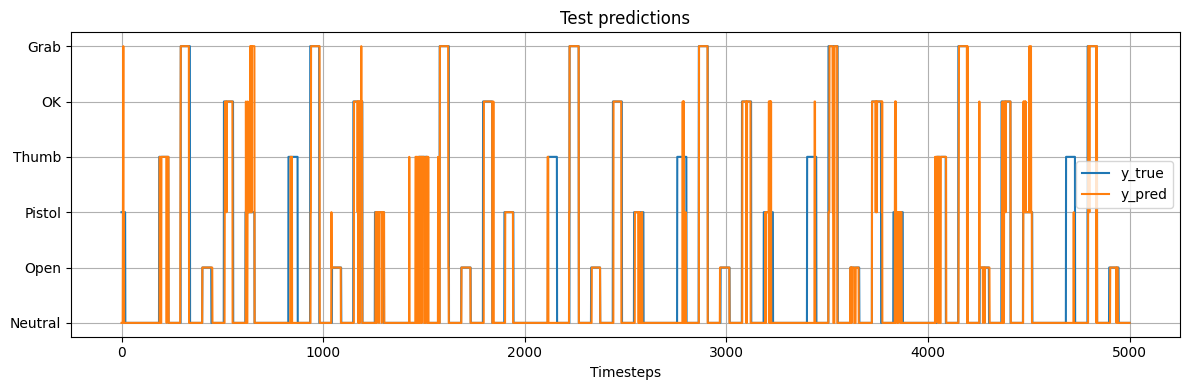

In [68]:
get_contingency_table(y_test_p1, preds_test_p1)
get_preds_plot(y_test_p1, preds_test_p1, start=0, end=5000)

По таблице сопряженности мы можем лучше оценить, насколько модель плохо предсказывает истинный класс: в частности, мы видим довольно большие промахи для жестов Thumb и Pistol (многое приписывается в Neutral). А на графике можем увидеть типичный участок предсказаний.

#### Модель для данных второго пилота

In [44]:
%%time
X_train_p2, X_test_p2, y_train_p2, y_test_p2 = loaded_dictionaries[1]['ce_p2_data_ar_']
model.fit(X_train_p2, y_train_p2)
preds_train_p2 = model.predict(X_train_p2)
preds_test_p2 = model.predict(X_test_p2)

CPU times: total: 27min 40s
Wall time: 2min 36s


,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,13354,92,110,72,152,52
Open,194,1537,2,0,6,1
Pistol,186,0,1609,0,2,4
Thumb,170,0,0,1487,78,3
OK,202,0,33,0,1502,0
Grab,185,0,35,1,7,1512


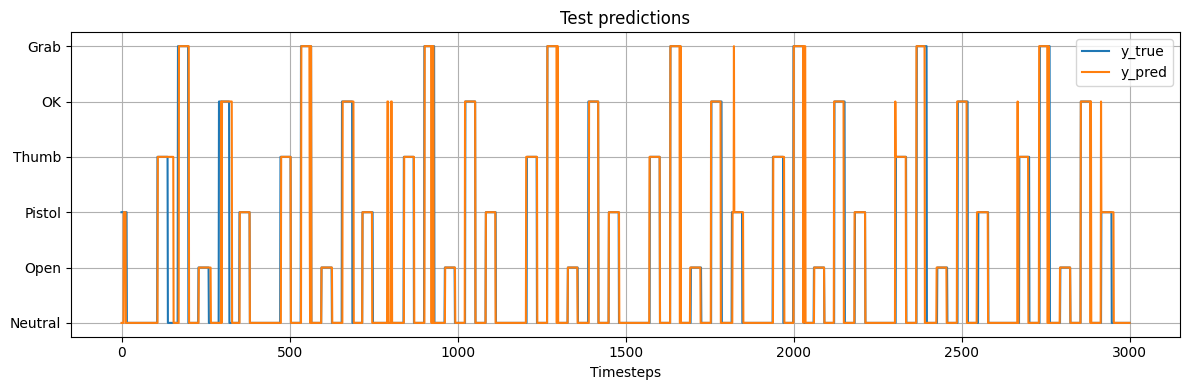

In [70]:
get_contingency_table(y_test_p2, preds_test_p2)
get_preds_plot(y_test_p2, preds_test_p2, start=0, end=3000)

Здесь предсказания уже выглядят более чистыми.

#### Модель для данных третьего пилота

In [45]:
%%time
X_train_p3, X_test_p3, y_train_p3, y_test_p3 = loaded_dictionaries[2]['p3_data_mm_ar']
model.fit(X_train_p3, y_train_p3)
preds_train_p3 = model.predict(X_train_p3)
preds_test_p3 = model.predict(X_test_p3)

CPU times: total: 23min 26s
Wall time: 2min 10s


,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,9813,14,78,93,46,37
Open,423,991,1,1,9,0
Pistol,116,0,1342,0,14,8
Thumb,581,5,3,838,8,1
OK,162,0,75,18,1122,56
Grab,58,0,27,0,8,1341


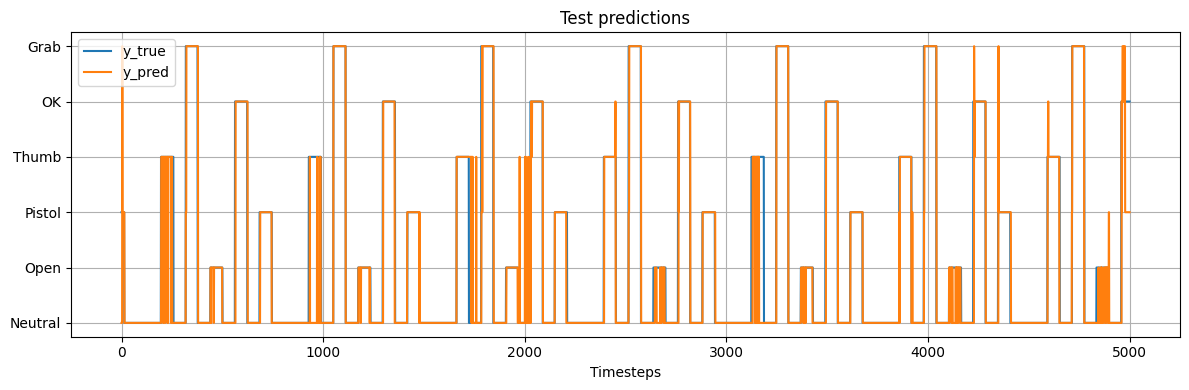

In [72]:
get_contingency_table(y_test_p3, preds_test_p3)
get_preds_plot(y_test_p3, preds_test_p3, start=0, end=5000)

Чище, чем у модели первого пилота, но хуже, чем у второго.

#### Модель для данных четвертого пилота

In [46]:
%%time
X_train_p4, X_test_p4, y_train_p4, y_test_p4 = loaded_dictionaries[3]['ce_p4_data_ar']
model.fit(X_train_p4, y_train_p4)
preds_train_p4 = model.predict(X_train_p4)
preds_test_p4 = model.predict(X_test_p4)

CPU times: total: 18min 35s
Wall time: 1min 41s


,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,3334,28,18,45,17,25
Open,16,470,0,0,0,0
Pistol,44,0,452,0,2,0
Thumb,20,0,0,464,0,0
OK,12,0,0,1,463,2
Grab,18,0,0,0,0,461


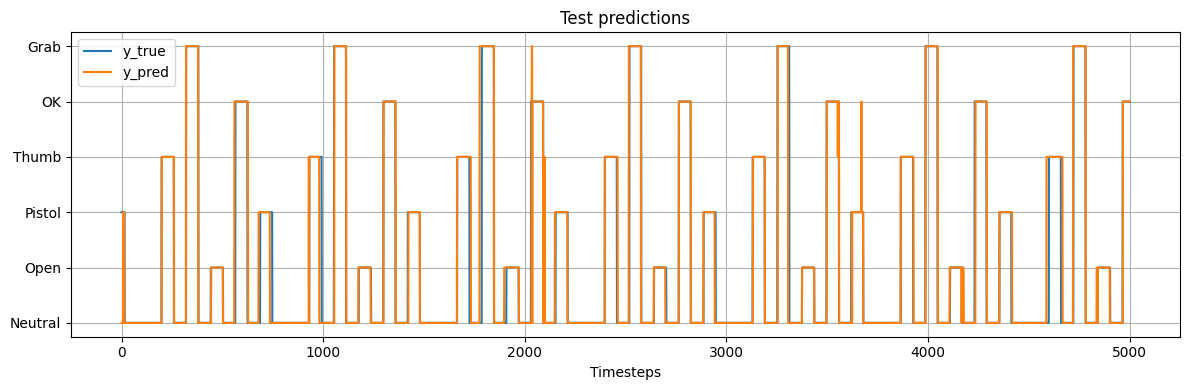

In [73]:
get_contingency_table(y_test_p4, preds_test_p4)
get_preds_plot(y_test_p4, preds_test_p4, start=0, end=5000)

Ну, это, разумеется, наилучший результат.

#### Генеральная модель

In [47]:
%%time
X_train_gm, X_test_gm, y_train_gm, y_test_gm = loaded_dictionaries[4]['ce_gm_data_ax_ar_']
model.fit(X_train_gm, y_train_gm)
preds_train_gm = model.predict(X_train_gm)
preds_test_gm = model.predict(X_test_gm)

CPU times: total: 36min 9s
Wall time: 3min 25s


In [75]:
get_contingency_table(y_test_gm, preds_test_gm)

,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,15281,31,61,131,77,53
Open,409,1566,0,0,1,0
Pistol,284,0,1703,0,16,40
Thumb,602,3,2,1333,36,0
OK,192,0,28,6,1737,6
Grab,111,10,36,0,8,1807


Таблица вроде бы неплохая, хоть и Neutral несколько раздут засчет прочих жестов.

Оценивать генеральную модель нужно с осторожностью: обучающие данные составлены из разных по качеству данных. Может так получиться, что предсказания генеральной модели для данных, например, первого пилота не отличаются по точности от предсказаний модели, обученной на данных только первого пилота (они могут также оказаться хуже). Т.е. наличие в обучающей выборке данных для прочих пилотов могло и не поспособствовать усвоению моделью дополнительных сведений о данных первого пилота, а высокая метрика F1 — заслуга участия других, более качественных, сетов.

Чтобы по достоиству оценить модель, нужно взять данные, на которых обучения не проводилось, преобразовать эти данные должным образом и совершить predict уже на них. Сперва мы выберем четыре сета (по одному на каждого пилота, в случае же четвертого мы просто сравним нашу модель с моделью для четвертого пилота).

Но прежде вспомним, какие сеты участвовали в обучении моделей выше:
* индексы сетов для модели первого пилота: 0, 4, 5;
* индексы сетов для модели второго пилота: 9, 16, 17, 28;
* индексы сетов для модели третьего пилота: 18, 20, 21;
* индексы сетов для модели четвертого пилота: 22;
* индексы сетов для генеральной модели: 0, 16, 18, 22;

Тогда индексами сетов для проверки генеральной модели будут: 4, 9, 20, 22.

In [86]:
# Подгрузим тестовые выборки
_, p1_4set_test_X, _, p1_4set_test_y = data_build([4])
_, p2_9set_test_X, _, p2_9set_test_y = data_build([9])
_, p3_20set_test_X, _, p3_20set_test_y = data_build([20])
_, p4_22set_test_X, _, p4_22set_test_y = data_build([22])

Далее нам необходимо преобразовать их так же, как были преобразованы данные, на которых получилось обучить лучшую генеральную модель. Ответом на вопрос, как именно, является имя ключа в словаре массивов для генеральной модели: `ce_gm_data_ax_ar_`.

Этот ключ сообщает нам, что нужно взять исходные данные (без нормализации или стандартизации) и объединить их со сгенерированными признаками, а затем произвести сглаживание данных. Создадим соответствующий конвейер.

In [80]:
def pipline(data):
    """Конвейер для получения
    преобразованных данных.

    Args:
        data (ndarray): исходная выборка данных.

    Returns:
        ndarray: преобразованная выборка.
    """
    data_ax = get_approx_lr_coefs(data)
    data_ar = get_ar_coefs(data)
    data_ax_ar_ = np.hstack([data, data_ax, data_ar])
    ce_data_ax_ar_ = get_convolve(data_ax_ar_, M=10, tau=1, sym=False)
    
    return ce_data_ax_ar_

Воспользуемся конвейером для получения преобразованных тестовых выборок.

In [85]:
ce_p1_4set_test_X_ax_ar_ = pipline(p1_4set_test_X)
ce_p2_9set_test_X_ax_ar_ = pipline(p2_9set_test_X)
ce_p3_20set_test_X_ax_ar_ = pipline(p3_20set_test_X)
ce_p4_22set_test_X_ax_ar_ = pipline(p4_22set_test_X)

Теперь все готово для тестов. Обучим заново модель на генеральных данных.

In [88]:
# Проверим, не убежала ли модель
model

In [89]:
# Приступим к обучению
model.fit(X_train_gm, y_train_gm)

# Сформируем векторы предсказаний
preds_test_p1_set4 = model.predict(ce_p1_4set_test_X_ax_ar_)
preds_test_p2_set9 = model.predict(ce_p2_9set_test_X_ax_ar_)
preds_test_p3_set20 = model.predict(ce_p3_20set_test_X_ax_ar_)
preds_test_p4_set22 = model.predict(ce_p4_22set_test_X_ax_ar_)

Составим из метрик датафрейм, как мы это уже не раз делали ранее и разукрасим таблицу.

In [95]:
preds_arrays = [
    preds_test_p1_set4, preds_test_p2_set9,
    preds_test_p3_set20, preds_test_p4_set22
]

y_true_list = [
    p1_4set_test_y, p2_9set_test_y,
    p3_20set_test_y, p4_22set_test_y
]

metrics_list = []
for i, preds in enumerate(preds_arrays):
    metrics_line = []
    f1_weighted = metrics.f1_score(y_true_list[i], preds, average='weighted')
    metrics_line.append(f1_weighted)
    
    for j in range(6):
        f1_test = metrics.f1_score(y_true_list[i], preds, average=None)[j]
        metrics_line.append(f1_test)
    
    metrics_list.append(metrics_line)

metrics_df = pd.DataFrame(
    metrics_list, columns=['F1_weighted', *GESTURES], 
    index=[n+1 for n in range(4)]
)

metrics_df.style.background_gradient(
    cmap='coolwarm',
    vmin=0, vmax=1,
    subset=list(metrics_df.columns)
)

,F1_weighted,Neutral,Open,Pistol,Thumb,OK,Grab
1,0.328225,0.509307,0.203670,0.000000,0.000000,0.002439,0.170085
2,0.459710,0.585968,0.386325,0.472641,0.152174,0.271169,0.133422
3,0.496311,0.758960,0.511111,0.003454,0.004065,0.074194,0.061290
4,0.952003,0.960187,0.959417,0.939734,0.897881,0.957336,0.947368


Получилось любопытно. Генеральная модель, судя по всему, вовсе не способна разобраться в данных, не вошедших в обучающую выборку. Косвенно мы уже осветили эту проблему в тетрадке `runs_report`: существует проблема несовместимости данных разных сетов, принадлежащих даже одним и тем же пилотам. В итоге получается так, что мы можем утверждать о наблюдаемом переобучении модели на данных конкретных сетов.

Как уже было отмечано ранее, в данном случае задача создания генеральной модели не является тривиальной. Насколько мне известно, даже в Моторике она остается нерешенной — там также для каждого конкретного случая добываются свои данные и модели обучаются именно на них и для них.

Но перейдем же к инференсу!

---

## Инференс

### Утилиты вывода

In [137]:
def preprocessing(x, prev, sample_size=10, alpha=0.5):
    if prev is None:
        x = np.delete(x.reshape(1, -1), features_to_remove, axis=1)
        prev = x
        y = x
    else:
        x = np.delete(x.reshape(1, -1), features_to_remove, axis=1)
        prev = np.vstack((prev, x))
        if prev.shape[0] < sample_size:
            prev_scaled = std_scaler.transform(prev)
            prev_pca = pca.transform(prev_scaled)
            y = get_smoothing(pd.DataFrame(prev_pca), sample_size=prev.shape[0], alpha=alpha)[-1]
        else:
            prev = prev[1:]
            prev_scaled = std_scaler.transform(prev)
            prev_pca = pca.transform(prev_scaled)
            y = get_smoothing(pd.DataFrame(prev_pca), sample_size=prev.shape[0], alpha=alpha)[-1]
    return y.reshape(1, -1), prev


def inference(x):
    y = model.predict(x)
    return y


def postprocessing(x, prev, length=5):
    if prev is None:
        prev = np.zeros((length,))
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    else:
        prev[1:] = prev[:-1]
        prev[0] = x
        prev = prev.astype(int)
        counts = np.bincount(prev)
        y = np.argmax(counts)
    return y, prev


def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y.reshape(1,)

## Inference

### Offline (dataset)

In [138]:
df_sim = test_pools[pilot_number-1]
print(df_sim.shape)

(5892, 65)


In [139]:
# Отключаем предупреждения DeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [140]:
LENGTH = 3
SAMPLE_SIZE = 10
ALPHA = 0.3

In [141]:
TIMEOUT = 0.05
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

ts_diffs = []
x_previous = None
y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed, x_previous = preprocessing(omg_sample, x_previous, sample_size=SAMPLE_SIZE, alpha=ALPHA)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed, y_previous = postprocessing(y_predicted, y_previous, length=LENGTH)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    # y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), f'Calculation cycle takes more than TIMEOUT, halting...\n{ts_diff}'
    ts_old = ts_start
    ts_diffs.append(ts_diff)
    i += 1 

In [142]:
print('Максимальное время на итерацию:', np.max(ts_diffs))

0.004995822906494141

In [143]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (5892, 50)
enc_sample.shape = (5892, 6)
sample_preprocessed.shape = (5892, 1, 46)
y_predicted.shape = (5892, 1)
y_postprocessed.shape = (5892,)
y_commands.shape = (5892, 1)


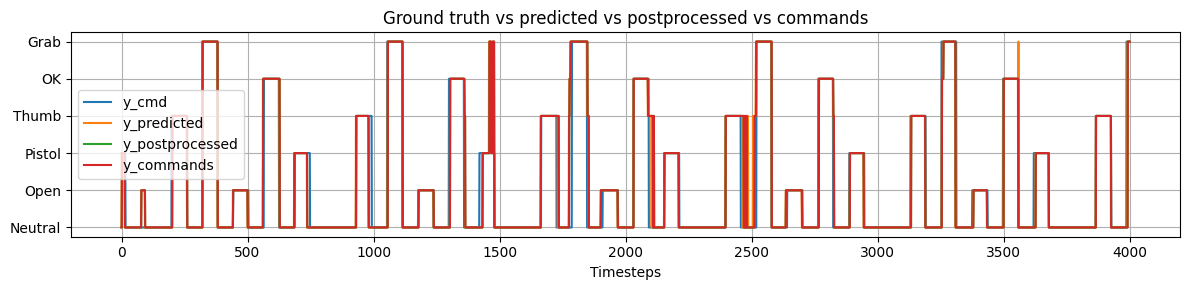

In [147]:
fig = plt.figure(figsize=(12, 3))

plt.plot(y_test[:4000], c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'][:4000], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'][:4000], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'][:4000], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [148]:
print(metrics.classification_report(
    y_test, y_dct['y_commands'], target_names=GESTURES, digits=4
))

# создаём таблицу сопряжённости
ct = pd.crosstab(y_test, y_dct['y_commands'].reshape(-1,))
# определяем название активностей
ct.index = ct.columns = GESTURES
ct

              precision    recall  f1-score   support

     Neutral     0.9533    0.9487    0.9510      3467
        Open     0.9333    0.9506    0.9419       486
      Pistol     0.9836    0.8434    0.9081       498
       Thumb     0.8136    0.9380    0.8714       484
          OK     0.9311    0.9331    0.9321       478
        Grab     0.9255    0.9332    0.9293       479

    accuracy                         0.9365      5892
   macro avg     0.9234    0.9245    0.9223      5892
weighted avg     0.9387    0.9365    0.9368      5892



,Neutral,Open,Pistol,Thumb,OK,Grab
Neutral,3289,33,7,99,16,23
Open,24,462,0,0,0,0
Pistol,65,0,420,0,0,13
Thumb,28,0,0,454,2,0
OK,27,0,0,5,446,0
Grab,17,0,0,0,15,447


|pilot|f1 weighted|
|-|-|
|`1`|0.6995|
|`2`|0.8921|
|`3`|0.8482|
|`4`|0.9368|

|pilot|max ts diff|
|-|:-:|
|`1`|0.008|
|`2`|0.012|
|`3`|0.006|
|`4`|0.005|

---